In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


In [2]:
# Load the dataset
df = pd.read_csv('churn_clean.csv', index_col=0)
#Check Data Types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   UID                   10000 non-null  object 
 3   City                  10000 non-null  object 
 4   State                 10000 non-null  object 
 5   County                10000 non-null  object 
 6   Zip                   10000 non-null  int64  
 7   Lat                   10000 non-null  float64
 8   Lng                   10000 non-null  float64
 9   Population            10000 non-null  int64  
 10  Area                  10000 non-null  object 
 11  TimeZone              10000 non-null  object 
 12  Job                   10000 non-null  object 
 13  Children              10000 non-null  int64  
 14  Age                   10000 non-null  int64  
 15  Income                10

In [3]:
df.head(5)

,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,Population,...,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
CaseOrder,,,,,,,,,,,,,,,,,,,,,
1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,38,...,172.455519,904.536110,5,5,5,3,4,4,3,4
2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,10446,...,242.632554,800.982766,3,4,3,3,4,3,4,4
3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,3735,...,159.947583,2054.706961,4,4,2,4,4,3,3,3
4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,dc8a365077241bb5cd5ccd305136b05e,Del Mar,CA,San Diego,92014,32.96687,-117.24798,13863,...,119.956840,2164.579412,4,4,4,2,5,4,3,3
5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,aabb64a116e83fdc4befc1fbab1663f9,Needville,TX,Fort Bend,77461,29.38012,-95.80673,11352,...,149.948316,271.493436,4,4,4,3,4,4,4,5


In [4]:
# Handle missing values and outliers
print("Initial Missing Values:")
print(df.isnull().sum())

# Identify columns with missing values
columns_with_missing = df.columns[df.isnull().any()]

# Replace missing values or drop rows/columns as needed
# Impute missing values for numerical columns (replace with mean)
for col in columns_with_missing:
    if df[col].dtype == 'float64' or df[col].dtype == 'int64':
        df[col].fillna(df[col].mean(), inplace=True)

# Impute missing values for categorical columns (replace with mode)
for col in columns_with_missing:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
# Display information about missing values after imputation
print("\nMissing Values After Imputation:")
print(df.isnull().sum())

Initial Missing Values:
Customer_id                0
Interaction                0
UID                        0
City                       0
State                      0
County                     0
Zip                        0
Lat                        0
Lng                        0
Population                 0
Area                       0
TimeZone                   0
Job                        0
Children                   0
Age                        0
Income                     0
Marital                    0
Gender                     0
Churn                      0
Outage_sec_perweek         0
Email                      0
Contacts                   0
Yearly_equip_failure       0
Techie                     0
Contract                   0
Port_modem                 0
Tablet                     0
InternetService         2129
Phone                      0
Multiple                   0
OnlineSecurity             0
OnlineBackup               0
DeviceProtection           0
TechSupport        

In [5]:
#Categorical Columns to Numeric
categorical_columns = ['Techie','Port_modem','Churn','OnlineSecurity','DeviceProtection', 'TechSupport', 'PaperlessBilling', 'Tablet', 'Phone', 'Multiple', 'OnlineBackup', 'StreamingTV', 'StreamingMovies']
for column in categorical_columns:
    df[column] = df[column].map({'Yes': 1, 'No': 0})

In [6]:
#Format
df['Age'] = df['Age'].fillna(0).astype(int)
df['Lng'] = df['Lng'].fillna(0).abs()
df['MonthlyCharge'] = df['MonthlyCharge'].fillna(0).astype(int)

In [7]:
area_mapping = {'Urban': 0,'Suburban': 1,'Rural': 2}
marital_mapping = {'Widowed': 0,'Married': 1,'Separated': 2,'Never Married': 3,'Divorced' :4}
gender_mapping = {'Male':0,'Female': 1,'Prefer not to answer': 2}
contract_mapping = {'One year': 0,'Month-to-month': 1,'Two Year': 2}
InternetService_mapping = {'DSL': 0,'Fiber Optic': 1,'None': 2}
PaymentMethod_mapping = {'Bank Transfer(automatic)': 0,'Credit Card (automatic)': 1,'Mailed Check': 2, 'Electronic Check': 3}



df['Area'] = df['Area'].map(area_mapping)
df['Marital'] = df['Marital'].map(marital_mapping)
df['Gender'] = df['Gender'].map(gender_mapping)
df['Contract'] = df['Contract'].map(contract_mapping)
df['InternetService'] = df['InternetService'].map(InternetService_mapping)
df['PaymentMethod'] = df['PaymentMethod'].map(PaymentMethod_mapping)

In [8]:
#Missing Values
df['Gender']= df['Gender'].fillna(df['Gender'].mode()[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   UID                   10000 non-null  object 
 3   City                  10000 non-null  object 
 4   State                 10000 non-null  object 
 5   County                10000 non-null  object 
 6   Zip                   10000 non-null  int64  
 7   Lat                   10000 non-null  float64
 8   Lng                   10000 non-null  float64
 9   Population            10000 non-null  int64  
 10  Area                  10000 non-null  int64  
 11  TimeZone              10000 non-null  object 
 12  Job                   10000 non-null  object 
 13  Children              10000 non-null  int64  
 14  Age                   10000 non-null  int32  
 15  Income                10

In [9]:
selected_columns = ['Age', 'Gender','Port_modem', 'OnlineSecurity', 'MonthlyCharge', 'Item1', 'Item2', 'Item3','Bandwidth_GB_Year','Churn' ]
data= df[selected_columns]

In [10]:
# Separate the X variables (explanatory) from the Y variable (response) into different dataframes
data_X = data.drop(["Churn"], axis=1).copy()
data_y = data["Churn"].copy()

In [11]:
# Standardize the X variables (explanatory) to put all on the same scale for KNN to measure distance
data_X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(data_X), columns=data_X.columns)
data_X

,Age,Gender,Port_modem,OnlineSecurity,MonthlyCharge,Item1,Item2,Item3,Bandwidth_GB_Year
0,0.704225,0.0,1.0,1.0,0.440758,0.666667,0.666667,0.571429,0.106951
1,0.126761,1.0,0.0,1.0,0.772512,0.333333,0.500000,0.285714,0.092165
2,0.450704,1.0,1.0,0.0,0.379147,0.500000,0.500000,0.142857,0.271180
3,0.422535,0.0,0.0,1.0,0.189573,0.500000,0.500000,0.428571,0.286868
4,0.915493,0.0,1.0,0.0,0.331754,0.500000,0.500000,0.428571,0.016561
...,...,...,...,...,...,...,...,...,...
9995,0.070423,0.0,1.0,0.0,0.379147,0.333333,0.166667,0.285714,0.907513
9996,0.422535,0.0,0.0,1.0,0.606635,0.500000,0.666667,0.571429,0.791099
9997,0.422535,1.0,0.0,1.0,0.426540,0.500000,0.500000,0.428571,0.571688
9998,0.295775,0.0,0.0,0.0,0.819905,0.500000,0.500000,0.714286,0.901403


In [12]:
data_y

CaseOrder
1        0
2        1
3        0
4        0
5        1
        ..
9996     0
9997     0
9998     0
9999     0
10000    0
Name: Churn, Length: 10000, dtype: int64

In [13]:
# Use SelectKBest to determine the best features to include in the model
feat_select = SelectKBest(f_classif, k='all')
feat_select.fit_transform(data_X, data_y)
feat_pvals = pd.DataFrame({'Feature' : data_X.columns, 'p_value' : feat_select.pvalues_}).sort_values('p_value') 
feat_pvals[feat_pvals['p_value'] < 0.05]

,Feature,p_value
4,MonthlyCharge,0.000000
8,Bandwidth_GB_Year,0.000000
1,Gender,0.005011


In [14]:
# Check VIF for multicollinearity issues amongst these features
X = data[["Gender", "MonthlyCharge","Bandwidth_GB_Year"]]

vif_df = pd.DataFrame()
vif_df["feature"] = X.columns

vif_df["VIF"] = [variance_inflation_factor(X.values, i)
for i in range(len(X.columns))]

print(vif_df)

             feature       VIF
0             Gender  1.980879
1      MonthlyCharge  3.886988
2  Bandwidth_GB_Year  3.122989


In [15]:
description =data.describe(include='all')
print(description)

                Age        Gender    Port_modem  OnlineSecurity  \
count  10000.000000  10000.000000  10000.000000    10000.000000   
mean      53.078400      0.525600      0.483400        0.357600   
std       20.698882      0.499369      0.499749        0.479317   
min       18.000000      0.000000      0.000000        0.000000   
25%       35.000000      0.000000      0.000000        0.000000   
50%       53.000000      1.000000      0.000000        0.000000   
75%       71.000000      1.000000      1.000000        1.000000   
max       89.000000      1.000000      1.000000        1.000000   

       MonthlyCharge         Item1         Item2         Item3  \
count   10000.000000  10000.000000  10000.000000  10000.000000   
mean      172.012800      3.490800      3.505100      3.487000   
std        43.031626      1.037797      1.034641      1.027977   
min        79.000000      1.000000      1.000000      1.000000   
25%       139.000000      3.000000      3.000000      3.000000   


In [16]:
data = data_X.copy()
data.insert(9, column="Churn", value=data_y.reset_index().drop('CaseOrder', axis=1))


In [17]:
# Save the cleaned dataset to a new CSV file
data.to_csv('cleaned_churn_data.csv', index=False)

In [18]:
X = data_X[["Gender", "MonthlyCharge","Bandwidth_GB_Year"]].assign(const=1)
y = data_y

# Split the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save the training and test sets to new CSV files
X_train.to_csv('train_data.csv', index=False)
X_test.to_csv('test_data.csv', index=False)
y_train.to_csv('train_labels.csv', index=False, header=True)
y_test.to_csv('test_labels.csv', index=False, header=True)

In [19]:
# Specify a range of values for k
k_values = list(range(1, 21))  # Adjust the range as needed

# Perform cross-validation for each value of k
cv_scores = []
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Find the best k with the highest cross-validated accuracy
best_k = k_values[cv_scores.index(max(cv_scores))]

# Print the results
print(f'Cross-validated accuracies for k values: {cv_scores}')
print(f'Best k: {best_k}')

Cross-validated accuracies for k values: [0.77925, 0.78975, 0.79925, 0.8065, 0.8096249999999999, 0.812375, 0.81225, 0.8161249999999999, 0.8190000000000002, 0.820875, 0.8223750000000001, 0.8210000000000001, 0.823625, 0.8238749999999999, 0.8242499999999999, 0.8248749999999999, 0.8241249999999999, 0.8252499999999999, 0.8266249999999999, 0.8285]
Best k: 20


In [20]:
# Specify a range of values for k
param_grid = {'n_neighbors': list(range(1, 21))}  # Adjust the range as needed

# Initialize the KNN classifier
knn_model = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and their corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the results
print(f'Best Parameters: {best_params}')
print(f'Best Cross-validated Accuracy: {best_score}')

Best Parameters: {'n_neighbors': 20}
Best Cross-validated Accuracy: 0.8285


In [21]:
# Train the final KNN model with the best 'k'
final_knn_model = KNeighborsClassifier(n_neighbors=best_k)
final_knn_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_test = final_knn_model.predict(X_test)

# Evaluate the final model on the test set
accuracy_test = accuracy_score(y_test, y_pred_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
classification_rep_test = classification_report(y_test, y_pred_test)

# Print the results on the test set
print(f'Final Model Accuracy on Test Set: {accuracy_test}')
print('\nConfusion Matrix (Test Set):\n', conf_matrix_test)
print('\nClassification Report (Test Set):\n', classification_rep_test)

Final Model Accuracy on Test Set: 0.8305

Confusion Matrix (Test Set):
 [[1344  112]
 [ 227  317]]

Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      1456
           1       0.74      0.58      0.65       544

    accuracy                           0.83      2000
   macro avg       0.80      0.75      0.77      2000
weighted avg       0.82      0.83      0.82      2000



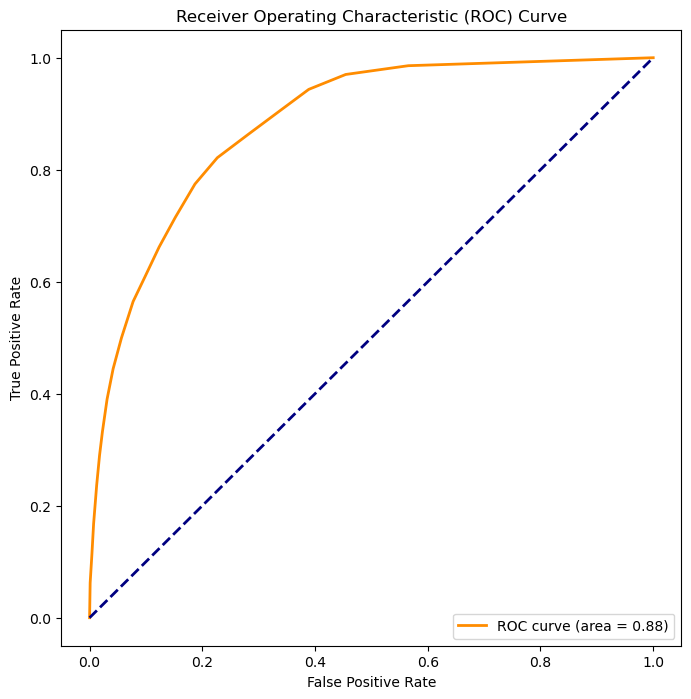

Confusion Matrix (Training Set):
 [[5497  397]
 [ 882 1224]]
Training Accuracy: 0.840125
Confusion Matrix (Test Set):
 [[1344  112]
 [ 227  317]]
Testing Accuracy: 0.8305


In [22]:
# ROC Curve
y_scores = cross_val_predict(final_knn_model, X_train, y_train, cv=5, method="predict_proba")[:, 1]
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred_train = final_knn_model.predict(X_train)
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print('Confusion Matrix (Training Set):\n', conf_matrix_train)

# Training Accuracy
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Training Accuracy:', accuracy_train)

# Testing Accuracy
y_pred_test = final_knn_model.predict(X_test)
conf_matrix_test = confusion_matrix(y_test, y_pred_test)
print('Confusion Matrix (Test Set):\n', conf_matrix_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print('Testing Accuracy:', accuracy_test)